In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-ivp-zerostability)=
# Zero-stability of multistep methods

```{index} multistep method
```

For one-step methods such as Runge–Kutta, {numref}`Theorem %s <theorem-euler-onestepGTE>` guarantees that the method converges and that the global error is of the same order as the local truncation error. For multistep methods, however, a new wrinkle is introduced. 

(demo-zs-LIAF)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

It is straightforward to check that the two-step method LIAF, defined by

```{math}
  :label: LIAF
  \mathbf{u}_{i+1} = -4u_i + 5u_{i-1} + h(4f_i + 2f_{i-1}),
```

is third-order accurate. Let's apply it to the ridiculously simple IVP $u'=u$, $u(0)=1$, whose solution is $e^t$. We'll measure the error at the time $t=1$.

In [2]:
dudt = (u,t) -> u
û = exp
a,b = 0.0,1.0;
n = [5,10,20,40,60]
err = []
t,u = [],[]
for n in n
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]
    u = [1; û(h); zeros(n-1)]
    f = [dudt(u[1],t[1]); zeros(n)]
    for i in 2:n
        f[i] = dudt(u[i],t[i])
        u[i+1] = -4*u[i] + 5*u[i-1] + h*(4*f[i]+2*f[i-1])
    end
    push!( err, abs(û(b) - u[end]) )
end

pretty_table( [n (b-a)./n err],["n","h","error"] )

┌────┬───────────┬────────────┐
│  n │         h │      error │
├────┼───────────┼────────────┤
│  5 │       0.2 │  0.0160452 │
│ 10 │       0.1 │    2.84548 │
│ 20 │      0.05 │   1.6225e6 │
│ 40 │     0.025 │  9.3442e18 │
│ 60 │ 0.0166667 │ 1.74013e32 │
└────┴───────────┴────────────┘


The error starts out promisingly, but things explode from there. A graph of the last numerical attempt yields a clue.

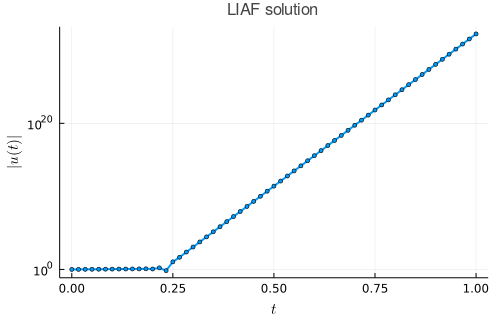

In [3]:
plot(t,abs.(u),m=3,label="",
    xlabel=L"t",yaxis=(:log10,L"|u(t)|"),title="LIAF solution")

It's clear that the solution is growing exponentially in time.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The source of the exponential growth in {numref}`Demo %s <demo-zs-LIAF>` is not hard to identify. Recall that we can rewrite {eq}`LIAF` as $\rho(\mathcal{Z})u_{i-1}=h \sigma(\mathcal{Z})u_{i-1}$ using the forward shift operator $\mathcal{Z}$:

```{math}
  :label: LIAFshift
  (\mathcal{Z}^2 + 4\mathcal{Z} - 5) u_{i-1} = h(4\mathcal{Z} + 2)f_{i-1}.
```

(See {eq}`multistepshift`, using $k=2$ here.) Next, suppose that $h$ is negligible in {eq}`LIAFshift`. Then the numerical solution of LIAF is roughly defined by

```{math}
  :label: LIAFshiftzero
  (\mathcal{Z}^2 + 4\mathcal{Z} - 5) u_{i-1} = 0.
```

The graph in {numref}`Demo %s <demo-zs-LIAF>` strongly suggests that for small $h$, $|u_i|\approx c \alpha^i$ for some $\alpha>1$ as $m$ gets large. So we are motivated to try defining 

```{math}
:label: zsansatz
u_i = c z^i
```

for all $i$ and see if we can prove that it is an exact solution. The beauty of this choice is that for all $i$,

$$\mathcal{Z} u_i = u_{i+1} = z u_i.$$

Hence {eq}`LIAFshiftzero` becomes

```{math}
  :label: LIAFcharzero
  z^2 + 4z - 5 = 0.
```

Therefore, as $h\to 0$, the two roots of $z^2+4z+5$ will each correspond to an approximate solution in the form {eq}`zsansatz` of the LIAF method. These roots are $z=1$ and $z=-5$, and the growth curve at the end of {numref}`Demo %s <demo-zs-LIAF>` is approximately $|(-5)^i|$. 

## Zero-stability

Here is the crucial property that LIAF lacks.

```{index} stability; of multistep methods
```

```{index} ! zero-stability
```

::::{proof:definition} Zero-stability of a multistep IVP method
A multistep method is **zero-stable** if, as $h\to 0$, every numerical solution produced by the method remains bounded throughout $a\le t_i \le b$.
::::

Without zero-stability, any truncation or roundoff error will get exponentially amplified and eventually overwhelm convergence to the exact solution. 

The following theorem concisely summarizes when we can expect zero-stability.

(theorem-zerostability-rootcondition)=
````{proof:theorem} Root condition
A linear multistep method is zero-stable if and only if every root $r$ of the generating polynomial $\rho(z)$ satisfies $|r|\le 1$, and any root $r$ with $|r|=1$ is simple.
````

````{proof:proof}
(Partial proof, when all roots of $\rho$ are simple.) As explained above, the values produced by the numerical method approach solutions of the difference equation $\rho(\mathcal{Z})u_{i-k+1}=0$. We consider only the case where the roots $r_1,\ldots,r_k$ of $\rho(z)$. Then $u_i=(r_j)^i$ is a solution of $\rho(\mathcal{Z})u_i=0$ for each $j=1,\ldots,k$. By linearity,

```{math}
  u_i = c_1 (r_1)^i + c_2 (r_2)^i + \cdots + c_k (r_k)^i
```

is a solution for any values of $c_1,\ldots,c_k$. These constants are determined uniquely by the starting values $u_0,\ldots,u_{k-1}$ (we omit the proof). Now, if all the roots satisfy $|r_j|\le 1$, then

```{math}
  |u_i| \le \sum_{j=1}^k |c_j| |r_j|^i \le \sum_{j=1}^k |c_j|,
```

independently of $h$ and $i$. This proves zero-stability. Conversely, if some $|r_j|>1$, then $|u_i|$ cannot be bounded above by a constant independent of $i$. Since $b=t_i$, $i\to\infty$ at $t=b$ as $h\to 0$, so zero-stability cannot hold.
````

A nonsimple root of $\rho$ introduces a modification of {eq}`zsansatz` that is considered in [Exercise 4](problem-zerostability-nonsimple).

````{proof:example}
A $k$-step Adams method has $\rho(z) = z^k - z^{k-1} = z^{k-1}(z-1)$. Hence 1 is a simple root and 0 is a root of multiplicity $k-1$. So the Adams methods are all stable.
````

::::{proof:example}
The method $u_{i+1} = 2u_i - u_{i-1} + h(f_i-f_{i-1})$ is first-order accurate. But $\rho(z)=(z-1)^2$, which has a double root at $z=1$, so it is not zero-stable.
::::

```{index} Dahlquist theorems
```
## Dahlquist theorems

It turns out that lacking zero-stability is the only thing that can go wrong for a consistent multistep method. 

(theorem-dahlequiv)=
```{proof:theorem} Dahlquist equivalence
A linear multistep method converges as $h\to 0$ if and only if it is consistent and zero-stable.
```

The Dahlquist equivalence theorem is one of the most important and celebrated in the history of numerical analysis. It can be proved more precisely that a zero-stable, consistent method is convergent in the same sense as {numref}`Theorem %s <theorem-euler-onestepGTE>`, with the error between numerical and exact solutions being of the same order as the local truncation error, for a wide class of problems.

You may have noticed that the Adams and BD formulas use only about half of the available data from the past $k$ steps, i.e., they have many possible coefficients set to zero. For instance, a $k$-step AB method uses only the $f_j$-values and has order $k$. The order could be made higher by also using $u_j$-values, like the LIAF method does for $k=2$. Also like the LIAF method, however, such attempts are doomed by instability.

(theorem-zerostability-dahlquist)=
````{proof:theorem} First Dahlquist stability barrier
The order of accuracy $p$ of a stable $k$-step linear multistep method satisfies

```{math}
p \le
\begin{cases}
  k+2 & \text{if $k$ is even},\\
  k+1 & \text{if $k$ is odd},\\
  k & \text{if the method is explicit.}
\end{cases}
```
````

The lesson of {numref}`Theorem {number} <theorem-zerostability-dahlquist>` is that accuracy is not the only important feature, and trying to optimize for it leads to failure. New lessons on the same theme appear in {numref}`section-diffusion-absstab`.

## Exercises

1. ✍ Show that the LIAF method {eq}`LIAF` has order of accuracy equal to 3.

2. ✍ / ⌨  Verify that the order of accuracy of the given multistep method is at least 1. Then apply {numref}`Theorem %s <theorem-zerostability-rootcondition>` to determine whether it is zero-stable.

    **(a)** BD2

    **(b)** BD3

    **(c)** $u_{i+1}=u_{i-1}+2hf_i$

    **(d)** $u_{i+1} = -u_i +u_{i-1} + u_{i-2} + \frac{2h}{3}(4f_i+f_{i-1}+f_{i-2})$

    **(e)** $u_{i+1} = u_{i-3} + \frac{4h}{3} ( 2f_i - f_{i-1} + 2f_{i-2})$

    **(f)** $u_{i+1} = -2u_i + 3u_{i-1} + h (f_{i+1}+2f_i+f_{i-1})$
  

3. ✍  A Fibonacci sequence is defined by $u_{i+1}=u_i+u_{i-1}$, where $u_0$ and $u_1$ are seed values. Using the proof of {numref}`Theorem %s <theorem-zerostability-rootcondition>`, find $r_1$ and $r_2$ such that $u_i=c_1(r_1)^i+c_2(r_2)^i$ for all $i$.

    (problem-zerostability-nonsimple)=
4. ✍ **(a)** Suppose that $\rho(r) = \rho'(r) = 0$. Show that $u_i = i r^i$ is a solution of the difference equation $\rho(\mathcal{Z})u_i=0$. 
    
    **(b)** Explain why the result of part (a) implies that a non-simple root $r$ with $|r|=1$ makes it impossible for a multistep method to be zero-stable.